# What is Semantic Segmentation?
Semantic segmentation refers to the process of linking each pixel in an image to a class label. These labels could include a person, car, flower, piece of furniture, etc., just to mention a few.
We can think of semantic segmentation as image classification at a pixel level. For example, in an image that has many cars, segmentation will label all the objects as car objects. However, a separate class of models known as instance segmentation is able to label the separate instances where an object appears in an image. This kind of segmentation can be very useful in applications that are used to count the number of objects, such as counting the amount of foot traffic in a mall.

# Please upvote the kernel if you found it insightful!

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip3 install -q segmentation-models-pytorch
!pip3 install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.6 MB/s eta 0:00:00


# Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

IMAGE_PATH = "/content/drive/MyDrive/inputs/"
MASK_PATH =  "/content/drive/MyDrive/semantic_annotations/"

In [4]:
n_classes = 17

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  1786


In [5]:
df = df.drop(257)

In [6]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  1365
Val Size     :  241
Test Size    :  179


Image Size (2250, 1550)
Mask Size (2250, 1550)


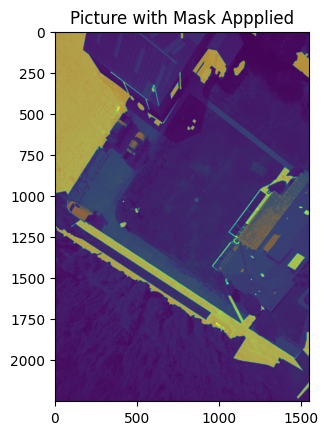

In [7]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [8]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #print(self.mask_path + self.X[idx] + '.png')
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        #print(np.unique(mask))
        mask[mask == 255] = 16
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

In [10]:
#device = torch.device("mps")
print(device)

cuda


In [11]:
model = smp.Unet('resnet18', encoder_weights='imagenet', classes=17, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s] 


In [12]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Training

In [13]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [14]:
"""
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=17):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
"""
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=17):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes - 1):  # loop per pixel class, excluding class 16
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)


In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #print(mask)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    #print(mask)
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-resnet18_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                # if not_improve == 7:
                #     print('Loss not decrease for 7 times, Stop Training')
                #     break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [16]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.561 
Epoch:1/50.. Train Loss: 2.137.. Val Loss: 1.561.. Train mIoU:0.115.. Val mIoU: 0.165.. Train Acc:0.385.. Val Acc:0.558.. Time: 15.98m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 1.561 >> 1.135 
Epoch:2/50.. Train Loss: 1.422.. Val Loss: 1.135.. Train mIoU:0.171.. Val mIoU: 0.231.. Train Acc:0.599.. Val Acc:0.685.. Time: 3.35m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 1.135 >> 0.991 
Epoch:3/50.. Train Loss: 1.155.. Val Loss: 0.991.. Train mIoU:0.235.. Val mIoU: 0.285.. Train Acc:0.662.. Val Acc:0.695.. Time: 3.32m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/50.. Train Loss: 1.045.. Val Loss: 0.995.. Train mIoU:0.270.. Val mIoU: 0.307.. Train Acc:0.687.. Val Acc:0.707.. Time: 3.39m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:5/50.. Train Loss: 0.998.. Val Loss: 1.047.. Train mIoU:0.283.. Val mIoU: 0.281.. Train Acc:0.699.. Val Acc:0.681.. Time: 3.37m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 1.047 >> 0.961 
saving model...
Epoch:6/50.. Train Loss: 0.974.. Val Loss: 0.961.. Train mIoU:0.285.. Val mIoU: 0.290.. Train Acc:0.702.. Val Acc:0.701.. Time: 3.41m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.961 >> 0.894 
Epoch:7/50.. Train Loss: 0.936.. Val Loss: 0.894.. Train mIoU:0.295.. Val mIoU: 0.308.. Train Acc:0.713.. Val Acc:0.717.. Time: 3.37m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:8/50.. Train Loss: 0.945.. Val Loss: 1.187.. Train mIoU:0.294.. Val mIoU: 0.286.. Train Acc:0.708.. Val Acc:0.674.. Time: 3.40m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 1.187 >> 0.904 
Epoch:9/50.. Train Loss: 0.936.. Val Loss: 0.904.. Train mIoU:0.323.. Val mIoU: 0.358.. Train Acc:0.711.. Val Acc:0.707.. Time: 3.32m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.904 >> 0.839 
Epoch:10/50.. Train Loss: 0.909.. Val Loss: 0.839.. Train mIoU:0.340.. Val mIoU: 0.370.. Train Acc:0.721.. Val Acc:0.732.. Time: 3.35m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.839 >> 0.823 
Epoch:11/50.. Train Loss: 0.881.. Val Loss: 0.823.. Train mIoU:0.351.. Val mIoU: 0.384.. Train Acc:0.727.. Val Acc:0.735.. Time: 3.34m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:12/50.. Train Loss: 0.884.. Val Loss: 0.952.. Train mIoU:0.352.. Val mIoU: 0.352.. Train Acc:0.725.. Val Acc:0.677.. Time: 3.34m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.952 >> 0.838 
saving model...
Epoch:13/50.. Train Loss: 0.840.. Val Loss: 0.838.. Train mIoU:0.370.. Val mIoU: 0.369.. Train Acc:0.739.. Val Acc:0.726.. Time: 3.39m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:14/50.. Train Loss: 0.806.. Val Loss: 0.878.. Train mIoU:0.381.. Val mIoU: 0.392.. Train Acc:0.749.. Val Acc:0.724.. Time: 3.39m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:15/50.. Train Loss: 0.799.. Val Loss: 1.122.. Train mIoU:0.383.. Val mIoU: 0.329.. Train Acc:0.752.. Val Acc:0.665.. Time: 3.32m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 1.122 >> 0.679 
Epoch:16/50.. Train Loss: 0.775.. Val Loss: 0.679.. Train mIoU:0.392.. Val mIoU: 0.441.. Train Acc:0.758.. Val Acc:0.783.. Time: 3.35m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:17/50.. Train Loss: 0.753.. Val Loss: 0.762.. Train mIoU:0.402.. Val mIoU: 0.413.. Train Acc:0.765.. Val Acc:0.750.. Time: 3.39m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.762 >> 0.742 
Epoch:18/50.. Train Loss: 0.718.. Val Loss: 0.742.. Train mIoU:0.412.. Val mIoU: 0.436.. Train Acc:0.774.. Val Acc:0.769.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:19/50.. Train Loss: 0.710.. Val Loss: 0.789.. Train mIoU:0.418.. Val mIoU: 0.417.. Train Acc:0.777.. Val Acc:0.745.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.789 >> 0.653 
Epoch:20/50.. Train Loss: 0.693.. Val Loss: 0.653.. Train mIoU:0.426.. Val mIoU: 0.460.. Train Acc:0.783.. Val Acc:0.790.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:21/50.. Train Loss: 0.668.. Val Loss: 0.765.. Train mIoU:0.433.. Val mIoU: 0.439.. Train Acc:0.791.. Val Acc:0.757.. Time: 3.35m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:22/50.. Train Loss: 0.646.. Val Loss: 1.010.. Train mIoU:0.443.. Val mIoU: 0.387.. Train Acc:0.796.. Val Acc:0.688.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 1.010 >> 0.665 
Epoch:23/50.. Train Loss: 0.639.. Val Loss: 0.665.. Train mIoU:0.444.. Val mIoU: 0.459.. Train Acc:0.798.. Val Acc:0.785.. Time: 3.41m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.665 >> 0.605 
saving model...
Epoch:24/50.. Train Loss: 0.618.. Val Loss: 0.605.. Train mIoU:0.457.. Val mIoU: 0.479.. Train Acc:0.804.. Val Acc:0.805.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:25/50.. Train Loss: 0.598.. Val Loss: 0.699.. Train mIoU:0.462.. Val mIoU: 0.455.. Train Acc:0.810.. Val Acc:0.777.. Time: 3.41m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.699 >> 0.604 
Epoch:26/50.. Train Loss: 0.585.. Val Loss: 0.604.. Train mIoU:0.468.. Val mIoU: 0.485.. Train Acc:0.814.. Val Acc:0.805.. Time: 3.40m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.604 >> 0.588 
Epoch:27/50.. Train Loss: 0.559.. Val Loss: 0.588.. Train mIoU:0.484.. Val mIoU: 0.502.. Train Acc:0.822.. Val Acc:0.811.. Time: 3.43m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.588 >> 0.569 
Epoch:28/50.. Train Loss: 0.554.. Val Loss: 0.569.. Train mIoU:0.485.. Val mIoU: 0.498.. Train Acc:0.823.. Val Acc:0.815.. Time: 3.37m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Epoch:29/50.. Train Loss: 0.534.. Val Loss: 0.577.. Train mIoU:0.493.. Val mIoU: 0.502.. Train Acc:0.829.. Val Acc:0.818.. Time: 3.36m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 13 time
Epoch:30/50.. Train Loss: 0.510.. Val Loss: 0.627.. Train mIoU:0.502.. Val mIoU: 0.488.. Train Acc:0.835.. Val Acc:0.799.. Time: 3.39m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 14 time
Epoch:31/50.. Train Loss: 0.499.. Val Loss: 0.994.. Train mIoU:0.507.. Val mIoU: 0.413.. Train Acc:0.839.. Val Acc:0.722.. Time: 3.40m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.994 >> 0.629 
Epoch:32/50.. Train Loss: 0.496.. Val Loss: 0.629.. Train mIoU:0.513.. Val mIoU: 0.495.. Train Acc:0.839.. Val Acc:0.798.. Time: 3.36m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.629 >> 0.582 
saving model...
Epoch:33/50.. Train Loss: 0.480.. Val Loss: 0.582.. Train mIoU:0.522.. Val mIoU: 0.509.. Train Acc:0.845.. Val Acc:0.813.. Time: 3.39m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.582 >> 0.529 
Epoch:34/50.. Train Loss: 0.471.. Val Loss: 0.529.. Train mIoU:0.525.. Val mIoU: 0.509.. Train Acc:0.847.. Val Acc:0.829.. Time: 3.39m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.529 >> 0.520 
Epoch:35/50.. Train Loss: 0.452.. Val Loss: 0.520.. Train mIoU:0.534.. Val mIoU: 0.523.. Train Acc:0.852.. Val Acc:0.832.. Time: 3.39m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.520 >> 0.509 
Epoch:36/50.. Train Loss: 0.441.. Val Loss: 0.509.. Train mIoU:0.539.. Val mIoU: 0.543.. Train Acc:0.856.. Val Acc:0.836.. Time: 3.34m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 15 time
Epoch:37/50.. Train Loss: 0.426.. Val Loss: 0.521.. Train mIoU:0.550.. Val mIoU: 0.544.. Train Acc:0.860.. Val Acc:0.838.. Time: 3.40m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.521 >> 0.509 
Epoch:38/50.. Train Loss: 0.412.. Val Loss: 0.509.. Train mIoU:0.553.. Val mIoU: 0.544.. Train Acc:0.864.. Val Acc:0.837.. Time: 3.35m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.509 >> 0.503 
saving model...
Epoch:39/50.. Train Loss: 0.408.. Val Loss: 0.503.. Train mIoU:0.558.. Val mIoU: 0.534.. Train Acc:0.865.. Val Acc:0.837.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 16 time
Epoch:40/50.. Train Loss: 0.401.. Val Loss: 0.506.. Train mIoU:0.562.. Val mIoU: 0.543.. Train Acc:0.868.. Val Acc:0.839.. Time: 3.34m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.506 >> 0.498 
Epoch:41/50.. Train Loss: 0.389.. Val Loss: 0.498.. Train mIoU:0.570.. Val mIoU: 0.548.. Train Acc:0.871.. Val Acc:0.842.. Time: 3.41m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.498 >> 0.489 
Epoch:42/50.. Train Loss: 0.378.. Val Loss: 0.489.. Train mIoU:0.573.. Val mIoU: 0.550.. Train Acc:0.875.. Val Acc:0.843.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 17 time
Epoch:43/50.. Train Loss: 0.372.. Val Loss: 0.502.. Train mIoU:0.577.. Val mIoU: 0.560.. Train Acc:0.877.. Val Acc:0.842.. Time: 3.35m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.502 >> 0.498 
Epoch:44/50.. Train Loss: 0.367.. Val Loss: 0.498.. Train mIoU:0.579.. Val mIoU: 0.555.. Train Acc:0.878.. Val Acc:0.843.. Time: 3.37m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.498 >> 0.498 
Epoch:45/50.. Train Loss: 0.358.. Val Loss: 0.498.. Train mIoU:0.585.. Val mIoU: 0.553.. Train Acc:0.881.. Val Acc:0.845.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.498 >> 0.485 
saving model...
Epoch:46/50.. Train Loss: 0.362.. Val Loss: 0.485.. Train mIoU:0.581.. Val mIoU: 0.552.. Train Acc:0.880.. Val Acc:0.845.. Time: 3.32m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.485 >> 0.485 
Epoch:47/50.. Train Loss: 0.356.. Val Loss: 0.485.. Train mIoU:0.586.. Val mIoU: 0.558.. Train Acc:0.882.. Val Acc:0.846.. Time: 3.40m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 18 time
Epoch:48/50.. Train Loss: 0.359.. Val Loss: 0.496.. Train mIoU:0.586.. Val mIoU: 0.554.. Train Acc:0.881.. Val Acc:0.844.. Time: 3.38m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Decreasing.. 0.496 >> 0.485 
Epoch:49/50.. Train Loss: 0.352.. Val Loss: 0.485.. Train mIoU:0.586.. Val mIoU: 0.558.. Train Acc:0.883.. Val Acc:0.847.. Time: 3.35m


  0%|          | 0/455 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Loss Not Decrease for 19 time
Epoch:50/50.. Train Loss: 0.356.. Val Loss: 0.496.. Train mIoU:0.585.. Val mIoU: 0.559.. Train Acc:0.881.. Val Acc:0.845.. Time: 3.39m
Total time: 181.27 m


In [17]:
torch.save(model, 'Unet-resnet18_2.pt')

In [18]:
torch.save(model,"/content/drive/MyDrive/Unet-resnet18_2.pt")

In [19]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

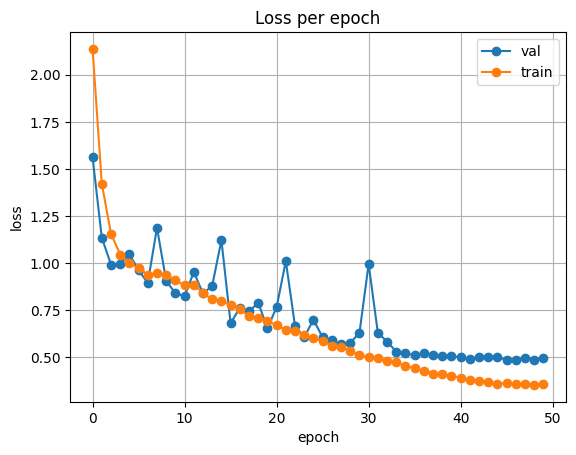

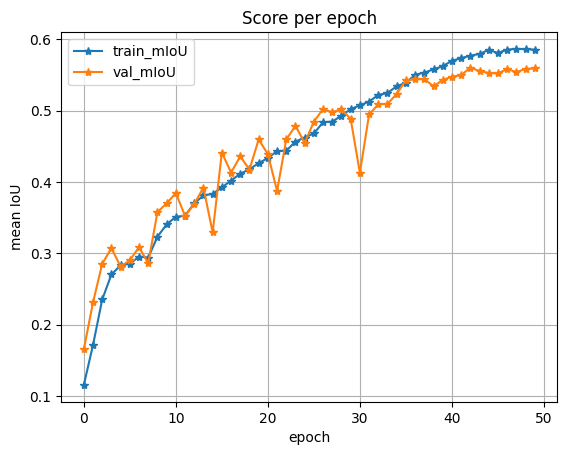

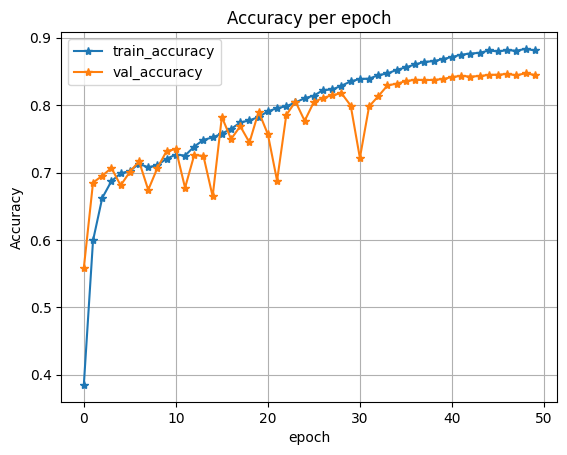

In [20]:
plot_loss(history)
plot_score(history)
plot_acc(history)